In [3]:
import os
import glob
import numpy as np
import pandas as pd

In [77]:
def load(test_output_dir, test):
    dfs = {}

    for dir in glob.glob(os.path.join(test_output_dir, test, '*')):
        _, specific = os.path.split(dir)
        specific = specific.split(test + '_')[1]

        csvs = glob.glob(os.path.join(dir, '*.csv'))
        dfs[specific] = [pd.read_csv(csv, index_col=0) for csv in csvs]

    for k in dfs.keys():
        print(k)
    
    return dfs

def plot_comparisons(species, dfs, anchor_name, comparison_names, **kwargs):
    anchor = dfs[anchor_name][0]
    comparisons = [dfs[n][0] for n in comparison_names]

    labels = [anchor_name] + comparison_names

    ax = anchor[species].plot.hist(**kwargs)

    for c in comparisons:
        c[species].plot.hist(ax=ax, **kwargs)

    ax.legend(labels)

In [137]:
# Cai and Petzold used K=50 for N=1,000,000 in the paper, but K probably should be chosen in reference to the size of the range?
# Probably worth experimenting with a range of Ks (it is super cheap to do so)

def histogram_distance(s1, s2, K):
    # a binned version of so-called "density distance"
    xmax = max(s1.max(), s2.max())
    xmin = min(s1.min(), s2.min())

    I = np.linspace(xmin, xmax, K)

    hist1, _ = np.histogram(s1, I)
    hist2, _ = np.histogram(s2, I)

    return np.sum(np.abs(hist1/len(s1) - hist2/len(s2)))

def self_distance(N, K):
    return np.sqrt(4*K / (np.pi * N))

def kolmogorov_distance(s1, s2):
    pass

def kolmogorov_self_distance(N):
    return np.log(2) * np.sqrt(np.pi/N)

## Decaying isomerization

In [82]:
test_output_dir = './cluster_output_june_7/'
test = 'decaying_isomerization'

dfs = load(test_output_dir, test)

ss_least_stiff_shortest_initial_ss_ss
less_stiff_short_hybrid
least_stiff_shortest_tau_10
stiff_long_hybrid
ss_less_stiff_short_initial_ss_hybrid
least_stiff_shortest_gillespie
least_stiff_shortest_hybrid_cle
ss_stiff_long_initial_ss_ss
least_stiff_shortest_hybrid
less_stiff_short_hybrid_cle
less_stiff_short_tau_10


In [83]:
anchor_name = 'least_stiff_shortest_gillespie'

comparison_names = [
    #'ss_least_stiff_shortest_initial_ss_ss'
    'least_stiff_shortest_hybrid',
    'least_stiff_shortest_hybrid_cle',
    #'least_stiff_shortest_tau_10',
]

species = 'S3'

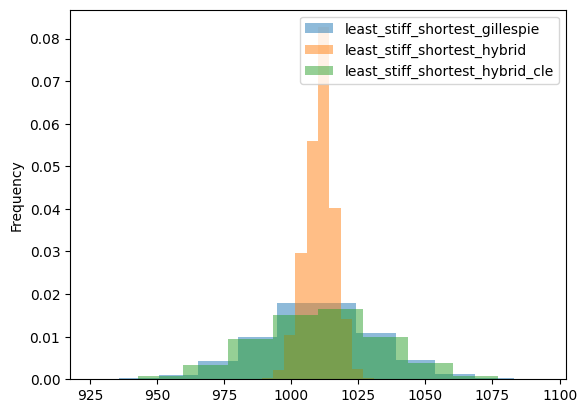

In [84]:
kwargs = {
    'density': True,
    #'bins': 15,
    'alpha': 0.5,
}

plot_comparisons(species, dfs, anchor_name, comparison_names, **kwargs)

## Schlogl

In [88]:
test_output_dir = './cluster_output_june_7/'
test = 'schlogl'

dfs = load(test_output_dir, test)

tau_30
hybrid_cle
hybrid
tau_70
tau_05
tau_50
tau_10
gillespie


In [91]:
anchor_name = 'gillespie'

comparison_names = [
    'tau_10',
]

species = 'X'

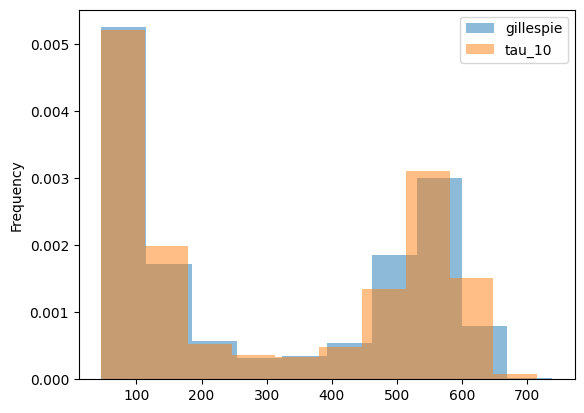

In [92]:
plot_comparisons(species, dfs, anchor_name, comparison_names, **kwargs)

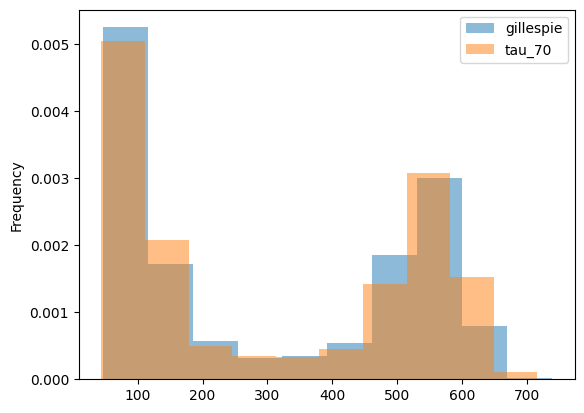

In [97]:
plot_comparisons(species, dfs, anchor_name, ['tau_70'], **kwargs)

In [134]:
gillespie_df = dfs['gillespie'][0]['X']

taus = ['tau_05', 'tau_10', 'tau_30', 'tau_50', 'tau_70']
taus = [dfs[n][0]['X'] for n in taus]

cle = dfs['hybrid_cle'][0]['X']

K = 100

In [133]:
[histogram_distance(gillespie_df, t, K) for t in taus]

[0.09559999999999999,
 0.0906,
 0.09219999999999999,
 0.08279999999999998,
 0.08239999999999997]

In [132]:
print("Gillespie self distance:", self_distance(gillespie_df, K))

Gillespie self distance: 0.11283791670955126


In [135]:
histogram_distance(gillespie_df, cle, K)

0.0938